# Solving Tolman–Oppenheimer–Volkoff equations 

The Tolman–Oppenheimer–Volkoff (TOV) equations are a set of differential equations that describe the structure of a spherically symmetric, static, and non-rotating star. The TOV equations are derived from the Einstein field equations and are used to determine the internal structure of a star, such as the pressure, density, and mass distribution. The TOV equations are given by:

\begin{align}
\frac{dP}{dr} &= -\frac{Gm(r) \rho(r)}{r^2} \left( 1 + \frac{P(r)}{\rho(r)c^2} \right) \left( 1 + \frac{4\pi r^3 P(r)}{m(r)c^2} \right) \left( 1 - \frac{2Gm(r)}{rc^2} \right)^{-1} \\
\frac{dm}{dr} &= 4\pi r^2 \rho(r) \\
\frac{d\ln A^{1/2}}{dr} &= \frac{Gm(r)}{r^2} \left( 1 + \frac{4\pi r^3 P(r)}{m(r)c^2} \right) \left( 1 - \frac{2Gm(r)}{rc^2} \right)^{-1}
\end{align}

where $P(r)$ is the pressure, $\rho(r)$ is the density, $m(r)$ is the mass enclosed within a radius $r$, $A(r)$ is the temporal component of the interior metric, $G$ is the gravitational constant, and $c$ is the speed of light. The TOV equations are solved by specifying the central density $\rho_c$ and integrating the equations from the center of the star to the surface. The star's radius is determined by the condition $P(R) = 0$, where $R$ is the radius of the star.

In this notebook, we will solve the TOV equations numerically and plot the pressure, density, and mass distribution of a star as a function of radius. We will also calculate the maximum mass of a white dwarf and compare it to observational constraints.

## Equation of state

We will focus on polytropic equations of state:

\begin{equation}
P = K \rho^{\gamma}
\end{equation}

where $P$ is the pressure, $\rho$ is the density, $K$ is a constant, and $\gamma$ is the stiffness index. 

In dimensionless for
\begin{equation}
\frac{p}{p_c}= \left( \frac{\rho}{\rho_c} \right)^{\gamma}
\end{equation}
where $p_c = {K} \rho_c^{\gamma}$ is the central pressure.


In [7]:
import numpy as np
from scipy.integrate import RK45

#PLOTS
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import sys
dir_base=sys.path[0]
dir_out=dir_base+"/figures/"

fontsz = 16
mpl.rcParams.update({'font.size': fontsz})

We define some relevant constants and units

In [5]:
G = 6.67430e-11 #m^3 kg^-1 s^-2
c = 2.99792458e8 #m/s
Msun = 1.98847e30 #kg

hbar = 1.0545718e-34 #m^2 kg / s
me = 9.10938356e-31 #kg
mH = 1.6735575e-27 #kg

We define the TOV equations

In [2]:
#Let's define the Tolman-Oppenheimer-Volkoff equations
def dpdr(rho, P, m, r):
    return -(G*m*rho/r**2)*(1 + P/rho/c**2)*(1 + 4*np.pi*r**3*P/(m*c**2))*(1 - 2*G*m/(r*c**2))**-1

def dmdr(rho,r):
    return 4*np.pi*r**2*rho

def dlnsqrtAdr(P, m, r):
    return (G*m/r**2)*(1 + 4*np.pi*r**3*P/(m*c**2))*(1 - 2*G*m/(r*c**2))**-1

By introducing $\bar p = p/p_c$, $\bar \rho = \rho/\rho_c$, $\bar m = m/M$, $\bar r = r/R$ we can rewrite the TOV equations in dimensionless form, where $M$ is the total mass of the star and $R$ is the radius of the star. We also introduce $f_c = \frac{p_c}{\rho_c c^2}$, $r_M = \frac{2GM}{c^2}$ and $\rho_R = \frac{3M}{4\pi R^3}$. 
With these definitions, the TOV equations become:

\begin{align}
\frac{d\bar p}{d\bar r} &= -\frac{r_M}{2Rf_c}\frac{\bar m \bar \rho}{\bar r^2} \left( 1 + f_c\frac{\bar p}{\bar \rho} \right) \left( 1 + \frac{3\rho_c f_c}{\rho_R}\frac{\bar r^3\bar p}{\bar m} \right) \left( 1 - \frac{r_M}{\bar r}\bar m \right)^{-1} \\
\frac{d\bar m}{d\bar r} &= 4\pi \bar r^2 \bar \rho \\
\end{align}

or in terms of $\bar\rho$

\begin{align}
\frac{d\bar \rho}{d\bar r} &= -\frac{r_M}{2Rf_c}\frac{d\bar\rho}{d\bar p}\frac{\bar m \bar \rho}{\bar r^2} \left( 1 + f_c\frac{\bar p}{\bar \rho} \right) \left( 1 + \frac{3\rho_c f_c}{\rho_R}\frac{\bar r^3\bar p}{\bar m} \right) \left( 1 - \frac{r_M}{\bar r}\bar m \right)^{-1} \\
\frac{d\bar m}{d\bar r} &= 4\pi \bar r^2 \bar \rho \\
\end{align}

In [77]:
#Let's define the Tolman-Oppenheimer-Volkoff equations in dimensionless form for a polytropic equation of state
def drhodr_dim(rho_d, p_d, m_d, r_d,M,R,rho_c,p_c,gamma):
    rho_R = M / (4./3*np.pi*R**3)
    f_c = p_c/rho_c/c**2
    rM = 2*G*M/c**2
    dpdrho = gamma*np.power(rho_d,gamma-1.)
    norm = (rM/2./R)/f_c
    jacobian = norm/dpdrho
    Newtonian = m_d*rho_d/r_d**2
    return -jacobian*Newtonian*(1 + f_c*p_d/rho_d)*(1 + 3*f_c*rho_c/rho_R*r_d**3*p_d/m_d)*(1 - rM/R*m_d/r_d)**-1

def dmdr_dim(rho_d,r_d,M,R,rho_c):
    rho_R = M / (4./3*np.pi*R**3)
    norm = 3*rho_c / rho_R
    return norm*r_d**2*rho_d


## White dwarf maximum mass

We compute the maximum mass of a white dwarf by solving the TOV equations for a range of central densities. 

For a white dwarf the stiffness parameter varies from $\gamma=5/3$ to $\gamma=4/3$ from the nonrelativistic to the ultrarelativistic limit.

In [78]:
#We define the equation of state
def eos(rho,p_c,rho_c,gamma):
    return p_c*np.power(rho/rho_c,gamma)

def eos_i(p,p_c,rho_c,gamma):
    return rho_c*(p/p_c)**(1/gamma)

def eos_dim(rho_d,gamma):
    return np.power(rho_d,gamma)

We solve the TOV equation for a fixed equation of state

In [85]:
#We solve the TOV equations using scipy's Runge-Kutta 4th order method

gamma = 4./3
p_c_fid = 1.06e27 #Pa #4e32#
rho_c_fid = 1e13 #kg/m^3 

rho_c = rho_c_fid#1e18 #kg/m^3
p_c = eos(rho_c,p_c_fid,rho_c_fid,gamma)
m_c = 1.e-40#1e-20 #kg

M = Msun #kg
R = 1000e3 #m

rho_R = M / (4./3*np.pi*R**3)
f_c = p_c/rho_c/c**2
rM = 2*G*M/c**2

def tov(r_d, y):
    rho_d, m_d= y
    p_d = eos_dim(rho_d,gamma)

    drhodr_dim_ = drhodr_dim(rho_d, p_d, m_d, r_d,M,R,rho_c,p_c,gamma)
    dmdr_dim_ = dmdr_dim(rho_d,r_d,M,R,rho_c)
    return [drhodr_dim_, dmdr_dim_]

y0 = [1., m_c]
r0 = 0.001
rf = 100.
dr = r0*10

#Check the order of magnitude of the factors in the TOV equations   
print('3rho_c/rho_R =',3*rho_c/rho_R )
print('r_M/R/f_c/2 =',1/f_c/2*(rM/R))

sol = RK45(tov,r0, y0,rf,max_step=dr)

3rho_c/rho_R = 63.19617904398443
r_M/R/f_c/2 = 1.2520420114150943


We solve the equations

In [86]:
r_values = []
rho_values = []
m_values = []

while sol.status == 'running':
    sol.step()
    r_values.append(sol.t)
    rho_values.append(sol.y[0])
    m_values.append(sol.y[1])
    if sol.status == 'finished':
        print('Integration finished')
        break

r_values = np.array(r_values)
rho_values = np.array(rho_values)
m_values = np.array(m_values)

p_values = eos_dim(rho_values, gamma)

/var/folders/gg/4d2p09ns5hzgcmdck5xdvgs40000gn/T/ipykernel_12506/2602589797.py:9: RuntimeWarning: invalid value encountered in power
  return np.power(rho_d,gamma)
/var/folders/gg/4d2p09ns5hzgcmdck5xdvgs40000gn/T/ipykernel_12506/2497435039.py:6: RuntimeWarning: invalid value encountered in power
  dpdrho = gamma*np.power(rho_d,gamma-1.)


R max:  1.5487484825103033  x  1000.0 km
M max:  1.4364249405495588  x  1.0 Msun
r_M_max/R_max =  2739.147378812598


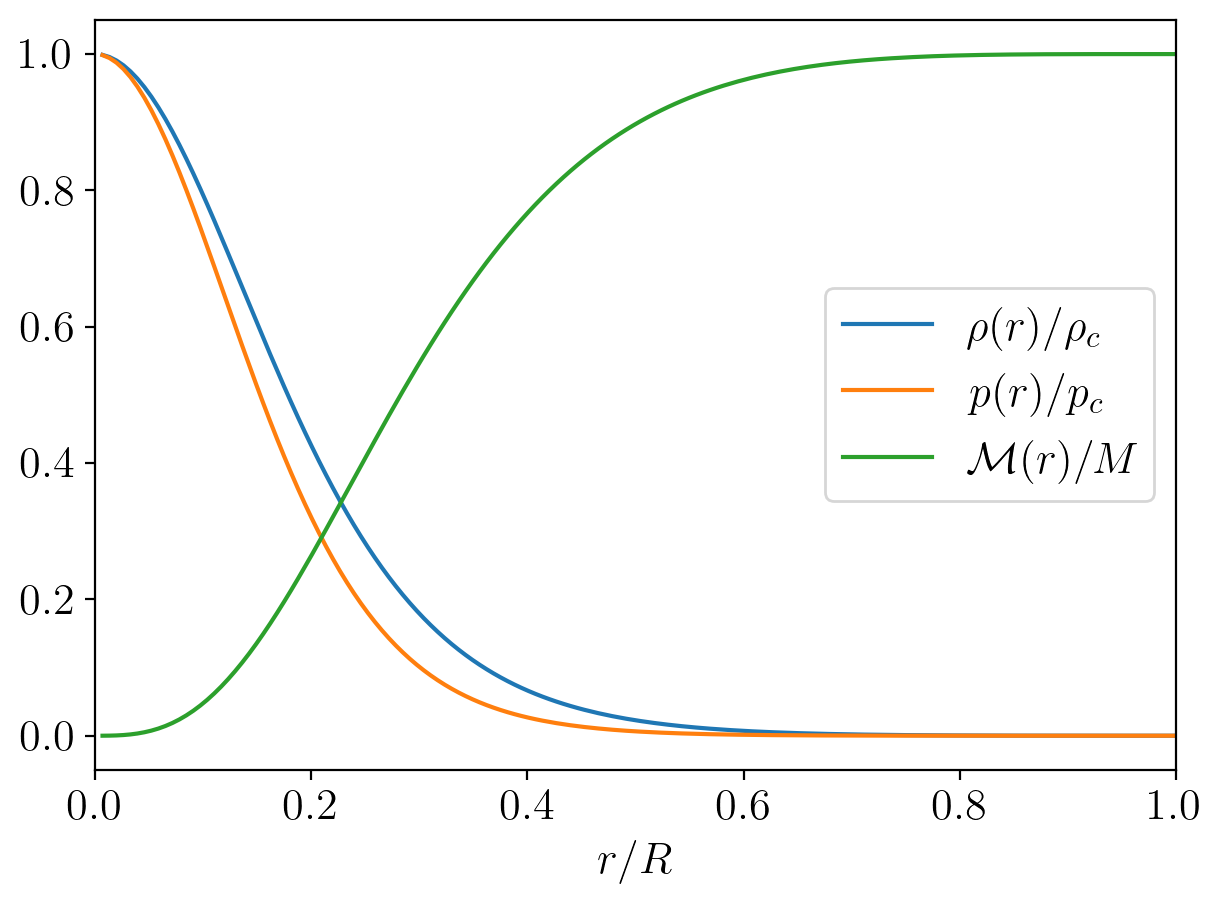

In [87]:
#We plot the results
fig, ax = plt.subplots(1, 1)#,figsize=(12, 6)

Rmax = np.max(r_values)
print('R max: ',Rmax,' x ',R/1000,'km')
Mmax = np.max(m_values)
print('M max: ',Mmax,' x ',M/Msun, 'Msun')
print('r_M_max/R_max = ',2*G*Mmax*Msun/c**2/Rmax)

ax.plot(r_values/Rmax, rho_values, label=r"$\rho(r)/\rho_c$")
ax.plot(r_values/Rmax, p_values, label=r"$p(r)/p_c$")
ax.plot(r_values/Rmax, m_values/Mmax, label=r"$\mathcal{M}(r)/M$")
ax.set_xlabel(r"$r/R$")
ax.set_xlim(0,1)

ax.legend()

plt.tight_layout()
plt.savefig(dir_out+"tov_solution.pdf")
plt.show()

## M vs. R

In the relativistic limit

In [101]:
gamma = 4./3
p_c_fid = 1.06e27 #Pa 
rho_c_fid = 1e13 #kg/m^3 

#Range of central densities
rho_cs = np.logspace(5,15,10) #kg/m^3
Rmaxs = np.zeros_like(rho_cs)
Mmaxs = np.zeros_like(rho_cs)

for i in range(len(rho_cs)):

    rho_c = rho_cs[i]
    p_c = eos(rho_c,p_c_fid,rho_c_fid,gamma)
    m_c = 1.e-30 #kg

    M = Msun #kg
    R = 1e6 #m

    rho_R = M / (4./3*np.pi*R**3)
    f_c = p_c/rho_c/c**2
    rM = 2*G*M/c**2

    def tov(r_d, y):
        rho_d, m_d= y
        p_d = eos_dim(rho_d,gamma)

        drhodr_dim_ = drhodr_dim(rho_d, p_d, m_d, r_d,M,R,rho_c,p_c,gamma)
        dmdr_dim_ = dmdr_dim(rho_d,r_d,M,R,rho_c)
        return [drhodr_dim_, dmdr_dim_]

    y0 = [1., m_c]
    r0 = 0.0001
    rf = 1e3
    dr = r0*10

    sol = RK45(tov,r0, y0,rf,max_step=dr)

    r_values = []
    rho_values = []
    m_values = []

    while sol.status == 'running':
        sol.step()
        r_values.append(sol.t)
        rho_values.append(sol.y[0])
        m_values.append(sol.y[1])
        if sol.status == 'finished':
            print('Integration finished')
            break

    r_values = np.array(r_values)
    rho_values = np.array(rho_values)
    m_values = np.array(m_values)

    Rmaxs[i] = np.max(r_values)
    Mmaxs[i] = np.max(m_values)


/var/folders/gg/4d2p09ns5hzgcmdck5xdvgs40000gn/T/ipykernel_12506/2602589797.py:9: RuntimeWarning: invalid value encountered in power
  return np.power(rho_d,gamma)
/var/folders/gg/4d2p09ns5hzgcmdck5xdvgs40000gn/T/ipykernel_12506/2497435039.py:6: RuntimeWarning: invalid value encountered in power
  dpdrho = gamma*np.power(rho_d,gamma-1.)


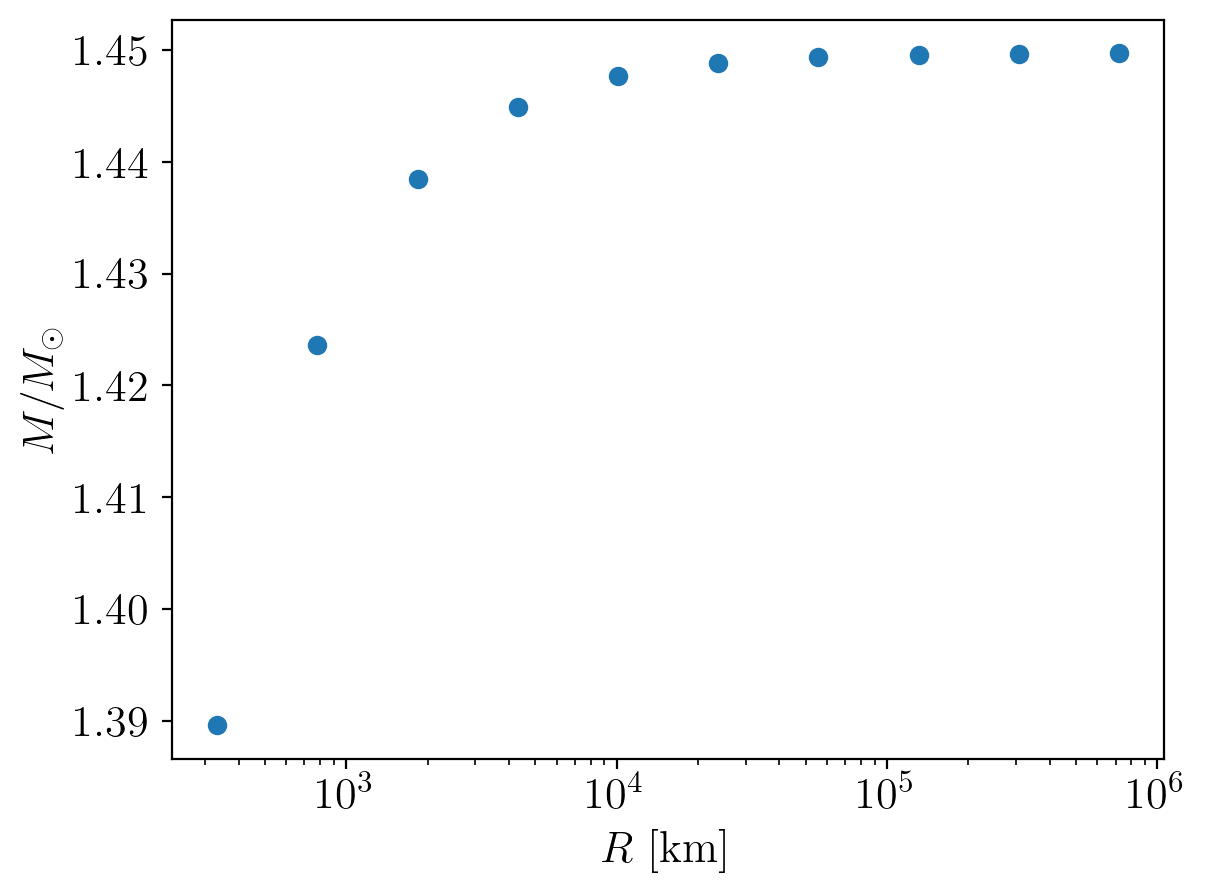

In [102]:
plt.semilogx(1e3*Rmaxs, Mmaxs, 'o')
plt.xlabel(r"$R$ [km]")
plt.ylabel(r"$M/M_\odot$")
plt.show()

In [103]:
# We store the relativistic resutls
Rmaxs_rel = Rmaxs
Mmaxs_rel = Mmaxs

In the non-relativistic limit

In [167]:
gamma = 5./3
p_c_fid = 1.06e27 #Pa 
rho_c_fid = np.power(10,12.5) #kg/m^3 # we fix this value to transition adequately to the relativistic regime

#Range of central densities
rho_cs = np.logspace(3,12,20) #kg/m^3
Rmaxs = np.zeros_like(rho_cs)
Mmaxs = np.zeros_like(rho_cs)

for i in range(len(rho_cs)):

    rho_c = rho_cs[i] #kg/m^3
    p_c = eos(rho_c,p_c_fid,rho_c_fid,gamma)
    m_c = 1.e-30 #kg

    M = Msun #kg
    R = 1e6 #m

    rho_R = M / (4./3*np.pi*R**3)
    f_c = p_c/rho_c/c**2
    rM = 2*G*M/c**2

    def tov(r_d, y):
        rho_d, m_d= y
        p_d = eos_dim(rho_d,gamma)

        drhodr_dim_ = drhodr_dim(rho_d, p_d, m_d, r_d,M,R,rho_c,p_c,gamma)
        dmdr_dim_ = dmdr_dim(rho_d,r_d,M,R,rho_c)
        return [drhodr_dim_, dmdr_dim_]

    y0 = [1., m_c]
    r0 = 0.001
    rf = 1e3
    dr = r0*10

    sol = RK45(tov,r0, y0,rf,max_step=dr)

    r_values = []
    rho_values = []
    m_values = []

    while sol.status == 'running':
        sol.step()
        r_values.append(sol.t)
        rho_values.append(sol.y[0])
        m_values.append(sol.y[1])
        if sol.status == 'finished':
            print('Integration finished')
            break

    r_values = np.array(r_values)
    rho_values = np.array(rho_values)
    m_values = np.array(m_values)

    Rmaxs[i] = np.max(r_values)
    Mmaxs[i] = np.max(m_values)


/var/folders/gg/4d2p09ns5hzgcmdck5xdvgs40000gn/T/ipykernel_12506/2602589797.py:9: RuntimeWarning: invalid value encountered in power
  return np.power(rho_d,gamma)
/var/folders/gg/4d2p09ns5hzgcmdck5xdvgs40000gn/T/ipykernel_12506/2497435039.py:6: RuntimeWarning: invalid value encountered in power
  dpdrho = gamma*np.power(rho_d,gamma-1.)


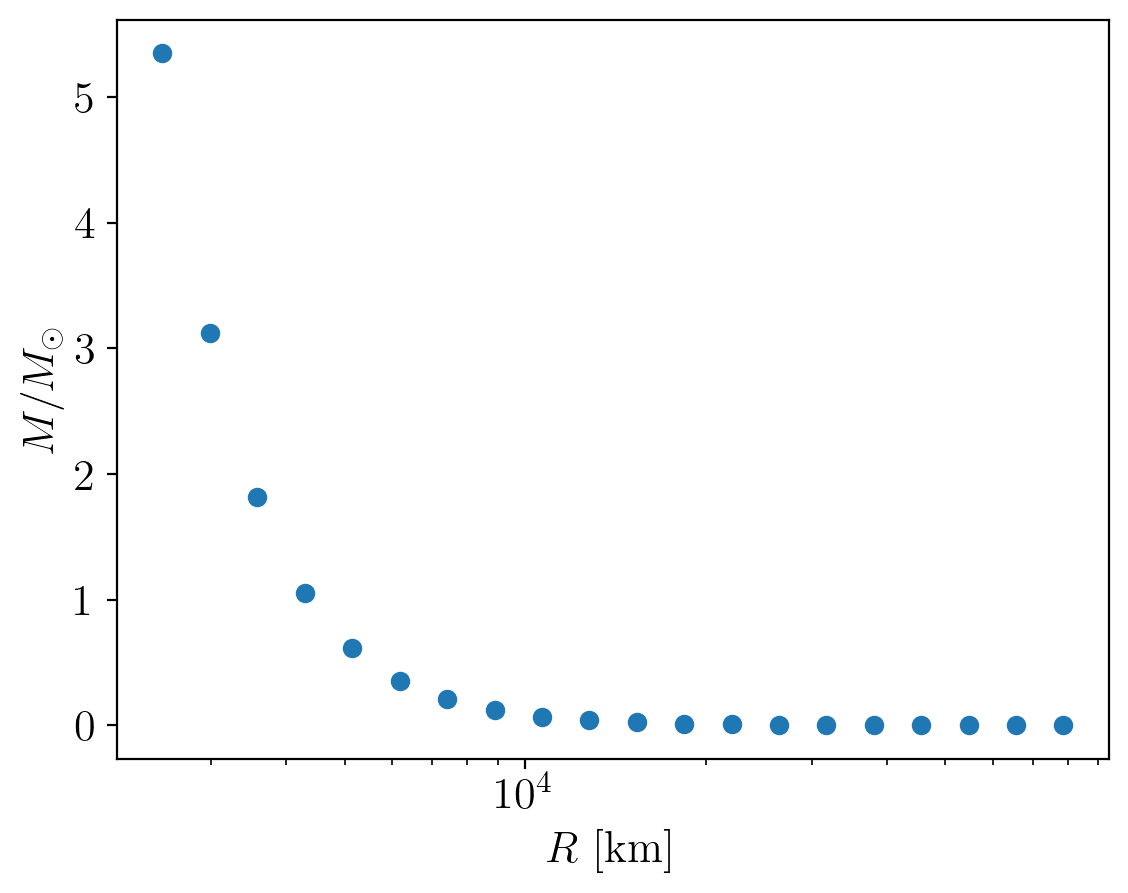

In [168]:
plt.semilogx(1e3*Rmaxs, Mmaxs, 'o')
plt.xlabel(r"$R$ [km]")
plt.ylabel(r"$M/M_\odot$")
plt.show()

In [169]:
# We store the non-relativistic resutls
Rmaxs_nonrel = Rmaxs
Mmaxs_nonrel = Mmaxs

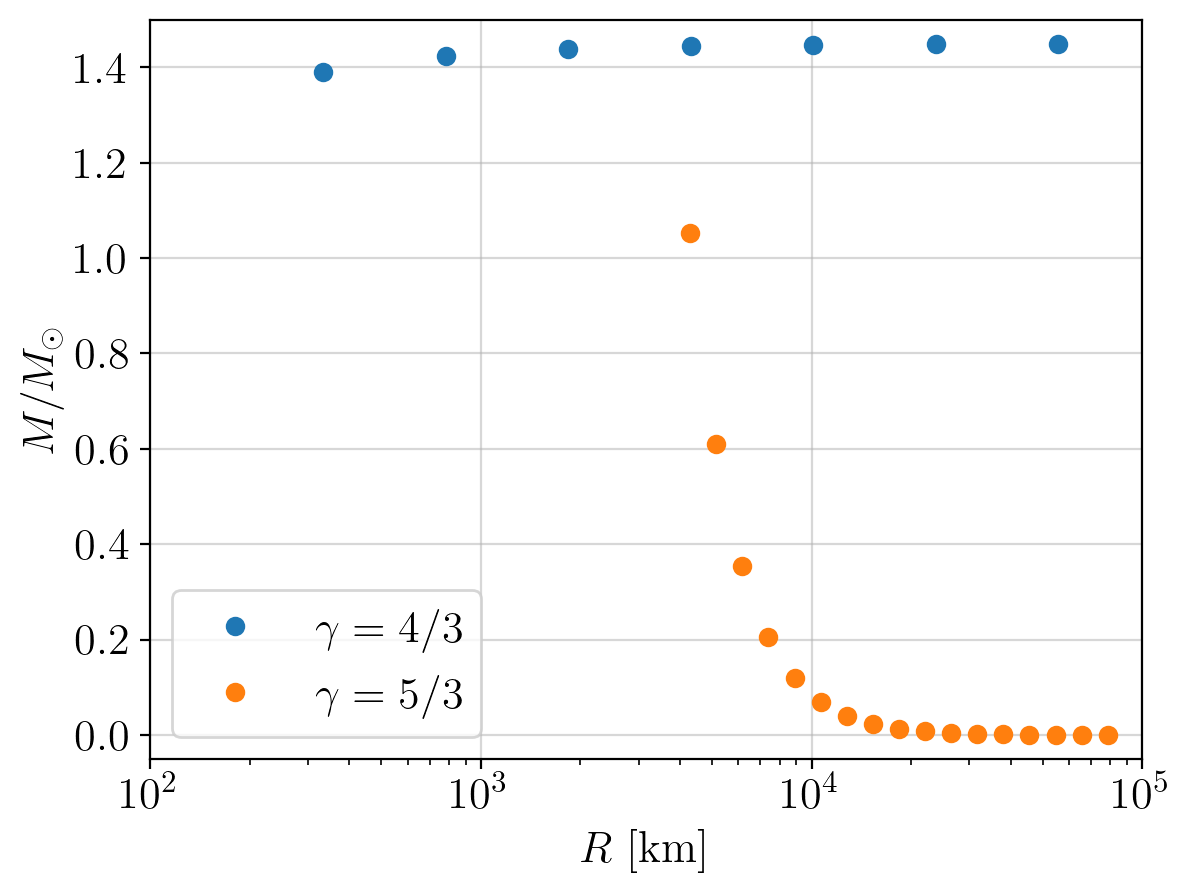

In [171]:
# We plot the results together

plt.semilogx(1e3*Rmaxs_rel, Mmaxs_rel, 'o', label=r"$\gamma=4/3$")
plt.semilogx(1e3*Rmaxs_nonrel, Mmaxs_nonrel, 'o', label=r"$\gamma=5/3$")
plt.xlabel(r"$R$ [km]")
plt.ylabel(r"$M/M_\odot$")
plt.ylim(-0.05,1.5)
plt.xlim(1e2,1e5)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

## Equation of state

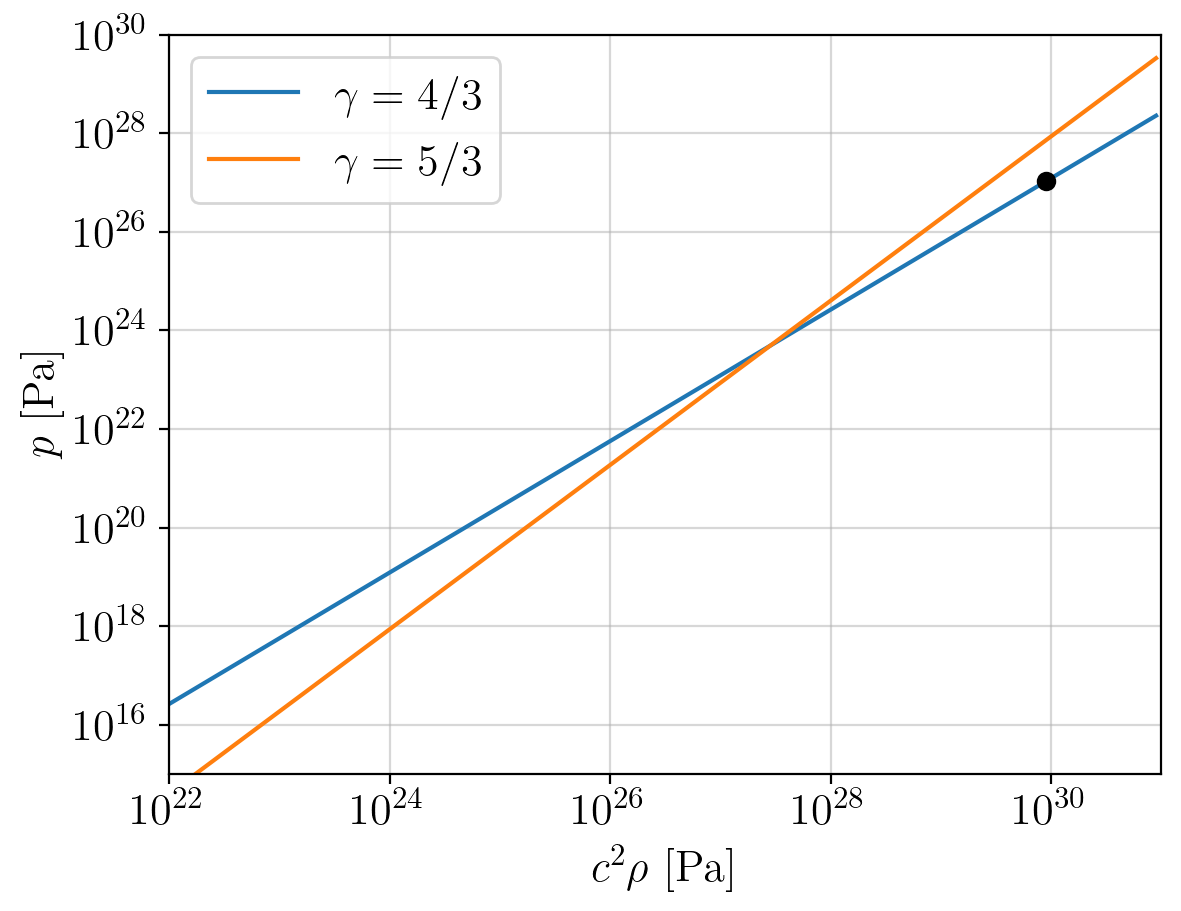

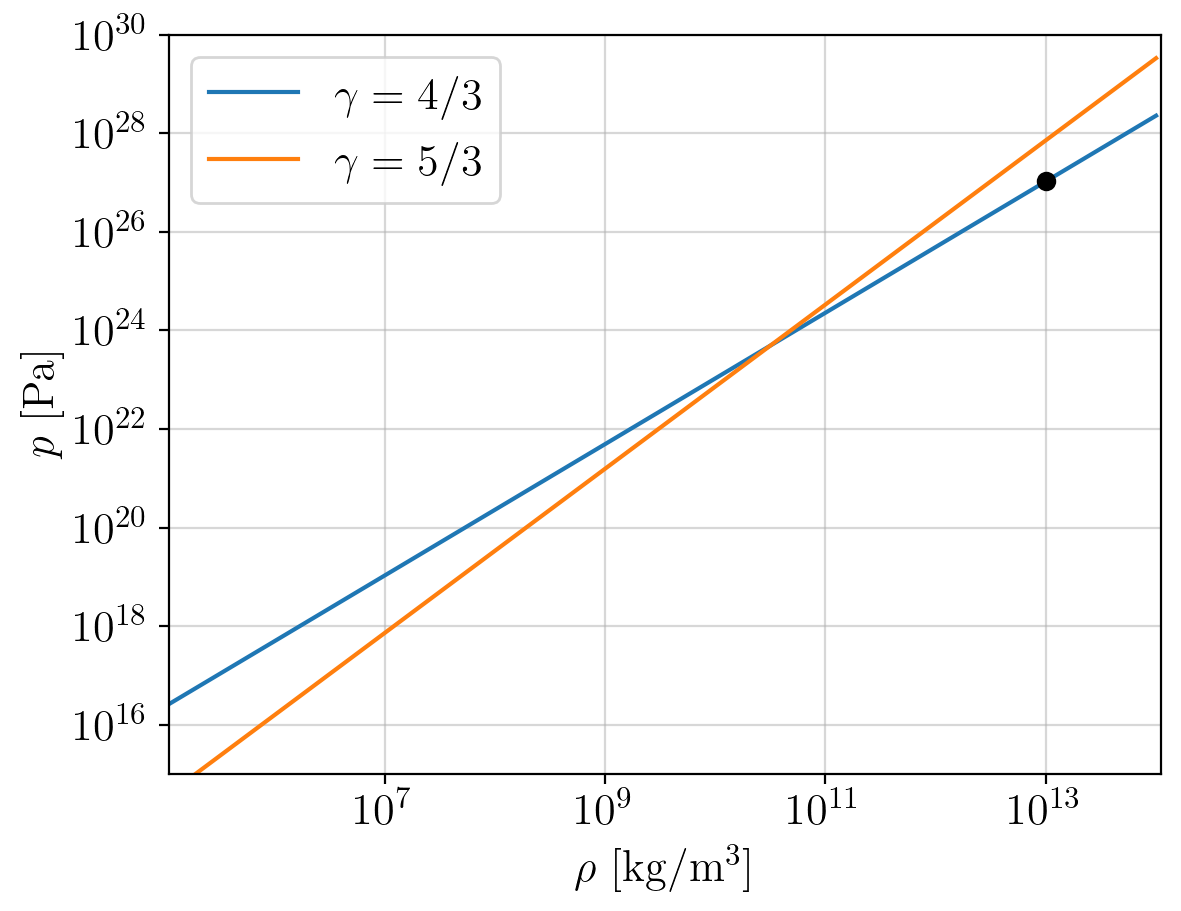

In [172]:
p_c_fid = 1.06e27 #Pa #4e32#
rho_c_fid = 1e13 #kg/m^3 
gamma_rel = 4./3
rho_s = np.logspace(3,14,100) #kg/m^3
p_s = eos(rho_s,p_c_fid,rho_c_fid,gamma_rel)

p_c_nr = 1.06e27 #Pa
rho_c_nr = np.power(10,12.5) #kg/m^3

gamma_nonrel = 5./3
p_s_nonrel = eos(rho_s,p_c_nr,rho_c_nr,gamma_nonrel)

plt.loglog(rho_s*c**2, p_s, label=r"$\gamma=4/3$")
plt.plot(rho_c_fid*c**2, p_c_fid, 'ko')
plt.loglog(rho_s*c**2, p_s_nonrel, label=r"$\gamma=5/3$")
plt.xlabel(r"$c^2\rho$ [Pa]")
plt.ylabel(r"$p$ [Pa]")
plt.legend()
plt.grid(alpha=0.5)
plt.xlim(1e22,1e31)
plt.ylim(1e15,1e30)
plt.show()

plt.loglog(rho_s, p_s, label=r"$\gamma=4/3$")
plt.plot(rho_c_fid, p_c_fid, 'ko')
plt.loglog(rho_s, p_s_nonrel, label=r"$\gamma=5/3$")
plt.xlabel(r"$\rho$ [kg/m$^3$]")
plt.ylabel(r"$p$ [Pa]")
plt.legend()
plt.grid(alpha=0.5)
plt.xlim(1e22/c**2,1e31/c**2)
plt.ylim(1e15,1e30)
plt.show()

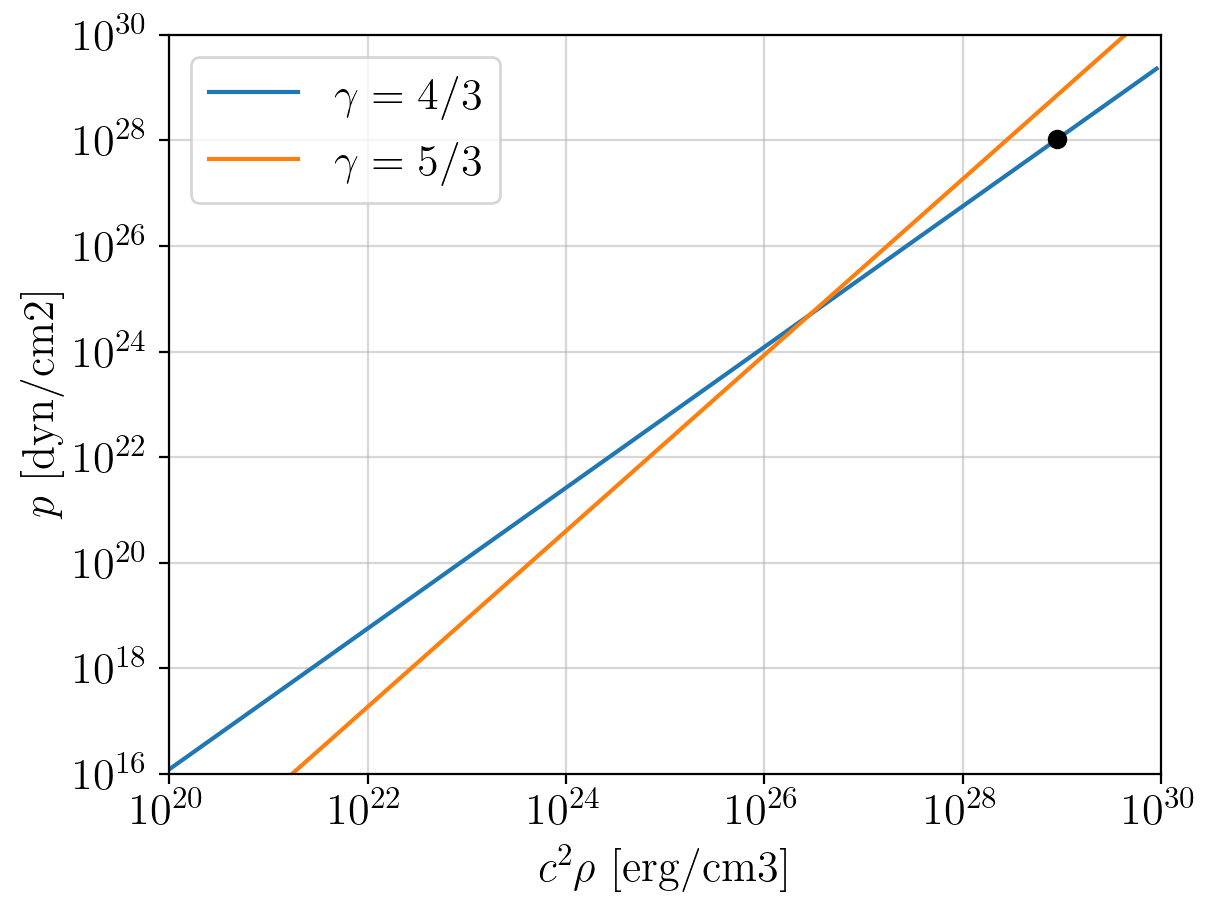

In [173]:
plt.loglog(rho_s*c**2/10, p_s/0.1, label=r"$\gamma=4/3$")
plt.plot(rho_c_fid*c**2/10, p_c_fid/0.1, 'ko')
plt.loglog(rho_s*c**2/10, p_s_nonrel/0.1, label=r"$\gamma=5/3$")
plt.xlabel(r"$c^2\rho$ [erg/cm3]")
plt.ylabel(r"$p$ [dyn/cm2]")
plt.legend()
plt.grid(alpha=0.5)
plt.xlim(1e20,1e30)
plt.ylim(1e16,1e30)
plt.show()